# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [3]:
LV_NAME = "LV66"

In [4]:
LV_AXIS_THRESHOLD = 3.0
N_TOP_SAMPLES = 200
N_TOP_ATTRS = 25

In [5]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv66')

In [6]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier_manuscript/content/images/lvs_analysis/lv66/lv66-cell_types.svg')

# Load MultiPLIER summary

In [7]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [8]:
multiplier_model_summary.shape

(2157, 5)

In [9]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [10]:
INPUT_SUBSET = "z_score_std"

In [11]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [12]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/bases_data/base_orig/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [13]:
data = pd.read_pickle(input_filepath)

In [14]:
data.shape

(3752, 987)

In [15]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## LV data

In [16]:
lv_obj = LVAnalysis(LV_NAME, data)

In [17]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

[2021-08-02 11:51:52,951 - numexpr.utils] INFO: NumExpr defaulting to 8 threads.


,pathway,LV index,AUC,p-value,FDR
316,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,66,0.615625,0.000024,0.000312


In [18]:
lv_data = lv_obj.get_experiments_data()

SRP048674, SRP029207, SRP021912, SRP051249, SRP040292, SRP055513, SRP055569, SRP057196, SRP050499, SRP017959, SRP029334, SRP045364, SRP043434, SRP049981, SRP042161, SRP008218, SRP020646, SRP011895, SRP012461, SRP021193, SRP012656, SRP026052, SRP050954, SRP037982, SRP049946, SRP027383, SRP022259, SRP049409, SRP056696, SRP018933, SRP002915, SRP033135, SRP009123, SRP058804, SRP043221, SRP066834, SRP050193, SRP048759, SRP047192, SRP050551, SRP008145, SRP060416, SRP044610, SRP050992, SRP004637, SRP044668, SRP057205, SRP058773, SRP042218, SRP016059, SRP058740, SRP040300, SRP020493, SRP039694, SRP040998, SRP058375, SRP056146, SRP010054, SRP039591, SRP019994, SRP014790, SRP014213, SRP007338, SRP029262, SRP014809, SRP018403, SRP041538, SRP063834, SRP034592, SRP018838, SRP007494, SRP050374, SRP002326, SRP007481, SRP030617, SRP026620, SRP052879, SRP015013, SRP033351, SRP058626, SRP061566, SRP039338, SRP017435, SRP044042, SRP015853, SRP007461, SRP007498, SRP003726, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 89)
  warnings.warn(


In [19]:
lv_data.shape

(7497, 121)

In [20]:
lv_data.head()

gender                cell type tissue  age  \
project   run                                                       
SRP048674 SRR1602519  female  ovarian granulosa cells    NaN  NaN   
          SRR1602520  female  ovarian granulosa cells    NaN  NaN   
          SRR1602521  female  ovarian granulosa cells    NaN  NaN   
          SRR1602522  female  ovarian granulosa cells    NaN  NaN   
          SRR1602524  female  ovarian granulosa cells    NaN  NaN   

                     stimulation protocol etiology of infertility  \
project   run                                                       
SRP048674 SRR1602519                  NaN                     NaN   
          SRR1602520                  NaN                     NaN   
          SRR1602521                  NaN                     NaN   
          SRR1602522                  NaN                     NaN   
          SRR1602524                  NaN                     NaN   

                     age in weeks genotype/variation gestational age  \
project   run                                                          
SRP048674 SRR1602519          NaN                NaN             NaN   
          SRR1602520          NaN                NaN             NaN   
          SRR1602521          NaN                NaN             NaN   
          SRR1602522          NaN                NaN             NaN   
          SRR1602524          NaN                NaN             NaN   

                     trimester  ... grade antibody catalog #  \
project   run                   ...                            
SRP048674 SRR1602519       NaN  ...   NaN                NaN   
          SRR1602520       NaN  ...   NaN                NaN   
          SRR1602521       NaN  ...   NaN                NaN   
          SRR1602522       NaN  ...   NaN                NaN   
          SRR1602524       NaN  ...   NaN                NaN   

                     antibody manufacturer culture medium knockdown  \
project   run                                                         
SRP048674 SRR1602519                   NaN            NaN       NaN   
          SRR1602520                   NaN            NaN       NaN   
          SRR1602521                   NaN            NaN       NaN   
          SRR1602522                   NaN            NaN       NaN   
          SRR1602524                   NaN            NaN       NaN   

                     time post transfection cell marker lentivirus shRNA seq  \
project   run                                                                  
SRP048674 SRR1602519                    NaN         NaN        NaN       NaN   
          SRR1602520                    NaN         NaN        NaN       NaN   
          SRR1602521                    NaN         NaN        NaN       NaN   
          SRR1602522                    NaN         NaN        NaN       NaN   
          SRR1602524                    NaN         NaN        NaN       NaN   

                          LV66  
project   run                   
SRP048674 SRR1602519  2.203988  
          SRR1602520  2.206297  
          SRR1602521  2.198754  
          SRR1602522  2.317331  
          SRR1602524  2.314041  

[5 rows x 121 columns]

# LV cell types analysis

## Get top attributes

In [21]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

gender                                     0.313166
genotype/variation                         0.106041
age in weeks                               0.051851
cell type                                  0.049005
age                                        0.025600
stimulation protocol                       0.025171
etiology of infertility                    0.025171
injury                                     0.016071
overexpression                             0.010165
maturation stage                           0.008527
tissue                                     0.008016
differentiation state                      0.007647
time                                       0.007647
gestational age                            0.007630
trimester                                  0.007630
Sex                                        0.006949
antibody vendor                            0.005606
antibody cat. #                            0.005606
library-type (for tophat and cufflinks)    0.005372
strain      

In [22]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type      0.049005
tissue         0.008016
tissue type    0.000788
dtype: float64

In [23]:
_tmp = lv_data.loc[
    :,
    [
        "cell type",
        "tissue",
        "tissue type",
        LV_NAME,
    ],
]

In [24]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [25]:
_tmp_seq[0]

cell type tissue tissue type      LV66
project   run                                                             
SRP048674 SRR1602550  ovarian granulosa cells    NaN         NaN  2.744975
          SRR1602549  ovarian granulosa cells    NaN         NaN  2.737186
          SRR1602548  ovarian granulosa cells    NaN         NaN  2.652381
          SRR1602547  ovarian granulosa cells    NaN         NaN  2.649500
          SRR1602541  ovarian granulosa cells    NaN         NaN  2.643815
          SRR1602540  ovarian granulosa cells    NaN         NaN  2.637845
          SRR1602546  ovarian granulosa cells    NaN         NaN  2.633940
          SRR1602536  ovarian granulosa cells    NaN         NaN  2.626521
          SRR1602535  ovarian granulosa cells    NaN         NaN  2.624989
          SRR1602534  ovarian granulosa cells    NaN         NaN  2.616970
          SRR1602538  ovarian granulosa cells    NaN         NaN  2.571853
          SRR1602539  ovarian granulosa cells    NaN         NaN  2.568345
          SRR1602532  ovarian granulosa cells    NaN         NaN  2.565834
          SRR1602537  ovarian granulosa cells    NaN         NaN  2.564073
          SRR1602533  ovarian granulosa cells    NaN         NaN  2.564058
          SRR1602531  ovarian granulosa cells    NaN         NaN  2.548941
          SRR1602544  ovarian granulosa cells    NaN         NaN  2.529479
          SRR1602545  ovarian granulosa cells    NaN         NaN  2.521069
          SRR1602543  ovarian granulosa cells    NaN         NaN  2.515922
          SRR1602529  ovarian granulosa cells    NaN         NaN  2.450982
          SRR1602530  ovarian granulosa cells    NaN         NaN  2.436911
          SRR1602528  ovarian granulosa cells    NaN         NaN  2.434601
          SRR1602522  ovarian granulosa cells    NaN         NaN  2.317331
          SRR1602524  ovarian granulosa cells    NaN         NaN  2.314041
          SRR1602526  ovarian granulosa cells    NaN         NaN  2.273020

In [26]:
# # what is there in these projects?
# lv_data.loc[["SRP056733"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

In [27]:
SELECTED_ATTRIBUTE = "cell type"

In [28]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue", "tissue type"]

## Get plot data

In [29]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [30]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [31]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [32]:
plot_data.head(20)

cell type      LV66
project   run                                          
SRP048674 SRR1602550  ovarian granulosa cells  2.744975
          SRR1602549  ovarian granulosa cells  2.737186
          SRR1602548  ovarian granulosa cells  2.652381
          SRR1602547  ovarian granulosa cells  2.649500
          SRR1602541  ovarian granulosa cells  2.643815
          SRR1602540  ovarian granulosa cells  2.637845
          SRR1602546  ovarian granulosa cells  2.633940
          SRR1602536  ovarian granulosa cells  2.626521
          SRR1602535  ovarian granulosa cells  2.624989
          SRR1602534  ovarian granulosa cells  2.616970
          SRR1602538  ovarian granulosa cells  2.571853
          SRR1602539  ovarian granulosa cells  2.568345
          SRR1602532  ovarian granulosa cells  2.565834
          SRR1602537  ovarian granulosa cells  2.564073
          SRR1602533  ovarian granulosa cells  2.564058
          SRR1602531  ovarian granulosa cells  2.548941
          SRR1602544  ovarian granulosa cells  2.529479
          SRR1602545  ovarian granulosa cells  2.521069
          SRR1602543  ovarian granulosa cells  2.515922
          SRR1602529  ovarian granulosa cells  2.450982

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [33]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma cells + lung fibroblast cells",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma cells + breast cancer cells",
        }
    }
)

In [34]:
# take the top samples only
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [35]:
final_plot_data.loc[
    final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [36]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
]

## Set x-axis order

In [37]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [38]:
len(attr_order)

25

In [39]:
attr_order[:5]

['ovarian granulosa cells',
 'ovary',
 'mural granulosa cells',
 'cumulus granulosa cells',
 'adrenal tumor']

## Plot

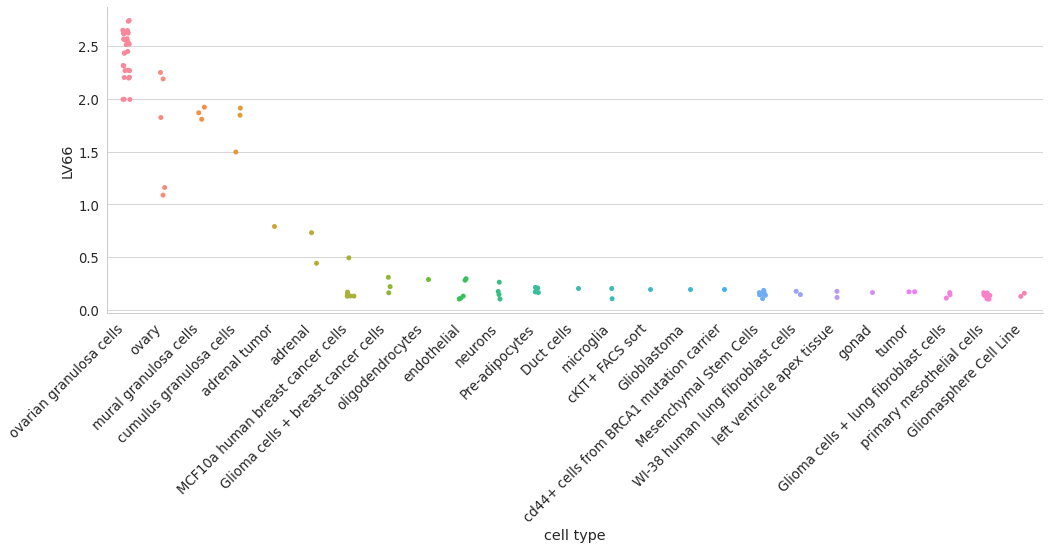

In [40]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    plt.savefig(
        OUTPUT_CELL_TYPE_FILEPATH,
        bbox_inches="tight",
        facecolor="white",
    )

# Debug

In [41]:
# with pd.option_context(
#     "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
# ):
#     _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("NOT CAT")]
#     display(_tmp.head(20))

In [42]:
# # what is there in these projects?
# lv_data.loc[["SRP036821"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).head(60)